In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
# Function to generate correlated exponential data
def generate_correlated_exponential(num_points, correlation_coefficient=0.2):
    """
    This is used as a helper function to generate correlated exponential data.
    
    Parameters:
    - num_points: Number of data points to generate.
    - correlation_coefficient: Correlation coefficient between the two variables.
    
    Returns:
    - x_correlated: Correlated exponential data for x.
    - y_correlated: Correlated exponential data for y.
    """
    # Generate independent exponential random variables
    x = np.random.exponential(size=num_points)
    y = np.random.exponential(size=num_points)

    # Covariance matrix for correlation
    covariance_matrix = np.array([[1, correlation_coefficient], [correlation_coefficient, 1]])

    # Apply the correlation
    scale = 0.3
    correlated_data = np.random.multivariate_normal([0, 0], covariance_matrix, size=num_points)
    x_correlated = np.exp(scale * correlated_data[:, 0])
    y_correlated = np.exp(scale * correlated_data[:, 1])

    return x_correlated, y_correlated

# Function to simulate a payment dataset using correlated exponential distribution
def generate_payment_data(num_transactions=1000, days=30):
    """
    Generate a payment dataset with correlated balances and amounts, including seasonality.
    
    Parameters:
    - num_transactions: Number of transactions to generate.
    - days: Number of days in the time span for the dataset.
    
    Returns:
    - DataFrame containing simulated transaction data.
    """
    # Define transaction types
    transaction_types = ['TRANSFER', 'CASH_OUT', 'DEPOSIT', 'PAYMENT']
    
    # Time span for the dataset
    end_time = datetime.now()
    start_time = end_time - timedelta(days=days)

    # Lists to store transaction data
    data = []

    # Generate correlated receiver_balance_before and amount
    receiver_balances, amounts = generate_correlated_exponential(num_transactions)

    # Scale the values to appropriate balance and amount ranges
    receiver_balances = receiver_balances * np.random.uniform(500, 50000)
    amounts = amounts * np.random.uniform(5, 5000)

    # Seasonality effect
    time_effect = np.linspace(0, 2 * np.pi, num_transactions)
    seasonality_factor = 1 + 0.5 * np.sin(time_effect)  # Sinusoidal seasonal pattern

    # Apply seasonal factor to balances and amounts
    receiver_balances = receiver_balances * seasonality_factor
    amounts = amounts * seasonality_factor

    # Simulate each transaction
    for i in range(num_transactions):
        # Choose random transaction type
        tx_type = np.random.choice(transaction_types)
        
        receiver_balance_before = receiver_balances[i]
        amount = min(amounts[i], receiver_balance_before)

        # Generate sender's balance as random
        sender_balance_before = np.random.uniform(500, 100000)

        # Adjust sender's and receiver's balances after transaction
        if tx_type != 'DEPOSIT':
            receiver_balance_after = receiver_balance_before + amount
            sender_balance_after = sender_balance_before - amount
        else:
            receiver_balance_after = receiver_balance_before - amount
            sender_balance_after = sender_balance_before + amount

        # Append transaction data
        data.append({
            'transaction_type': tx_type,
            'sender_balance_before': sender_balance_before,
            'sender_balance_after': sender_balance_after,
            'receiver_balance_before': receiver_balance_before,
            'receiver_balance_after': receiver_balance_after,
            'amount': amount,
            'transaction_time': start_time + timedelta(seconds=np.random.randint(0, int((end_time - start_time).total_seconds())))
        })

    return pd.DataFrame(data)

# Generate transaction data
transaction_data = generate_payment_data(num_transactions=3000)

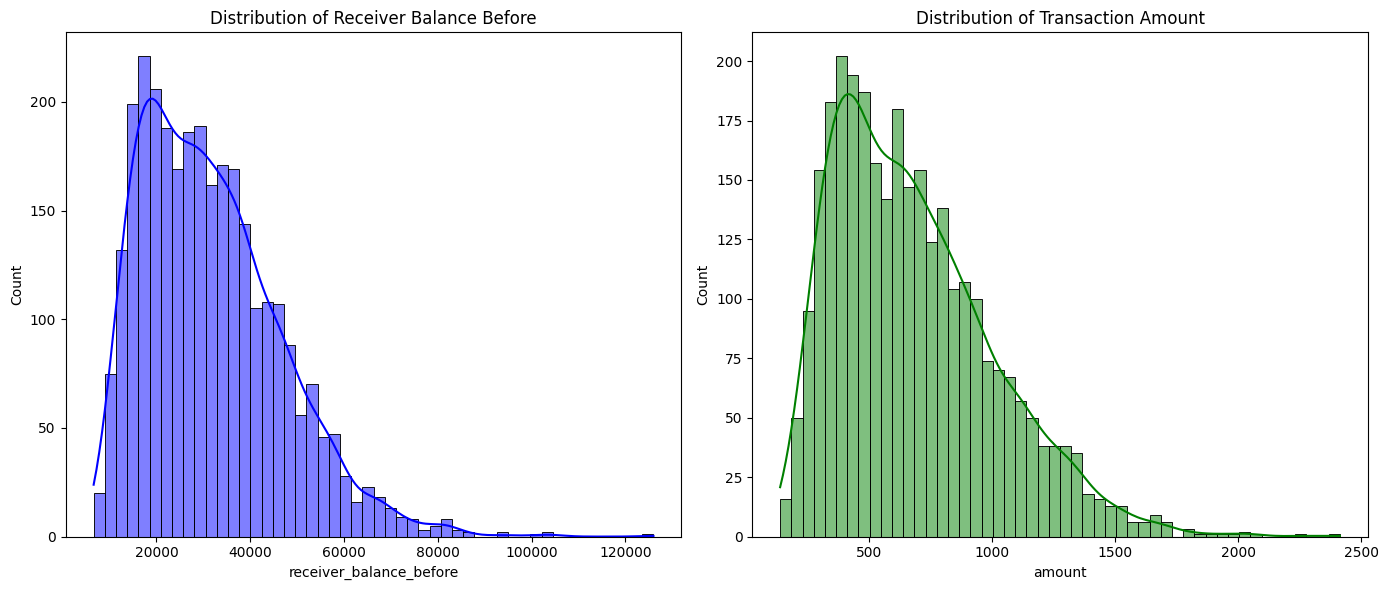

In [3]:
# Plot distribution of receiver_balance_before and amount
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(transaction_data['receiver_balance_before'], bins=50, kde=True, color='blue')
plt.title('Distribution of Receiver Balance Before')

plt.subplot(1, 2, 2)
sns.histplot(transaction_data['amount'], bins=50, kde=True, color='green')
plt.title('Distribution of Transaction Amount')

plt.tight_layout()
plt.show()

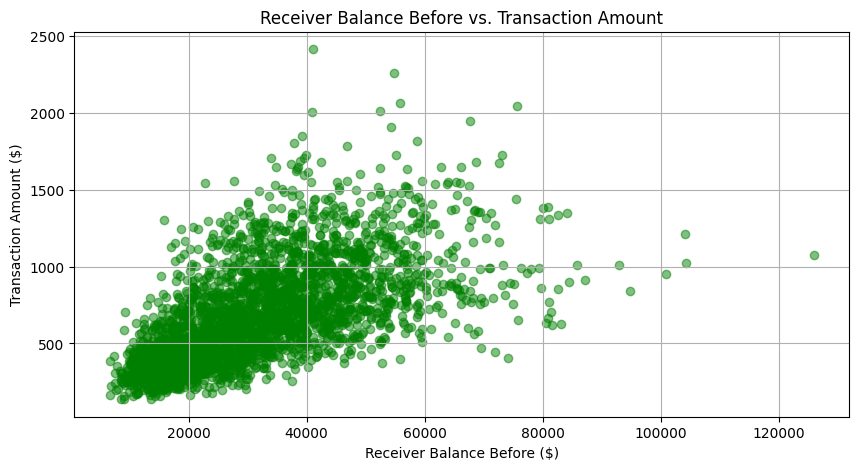

In [4]:
# Scatter plot between receiver_balance_before and transaction amount
plt.figure(figsize=(10, 5))
plt.scatter(transaction_data['receiver_balance_before'], transaction_data['amount'], alpha=0.5, color='green')
plt.title('Receiver Balance Before vs. Transaction Amount')
plt.xlabel('Receiver Balance Before ($)')
plt.ylabel('Transaction Amount ($)')
plt.grid(True)
plt.show()

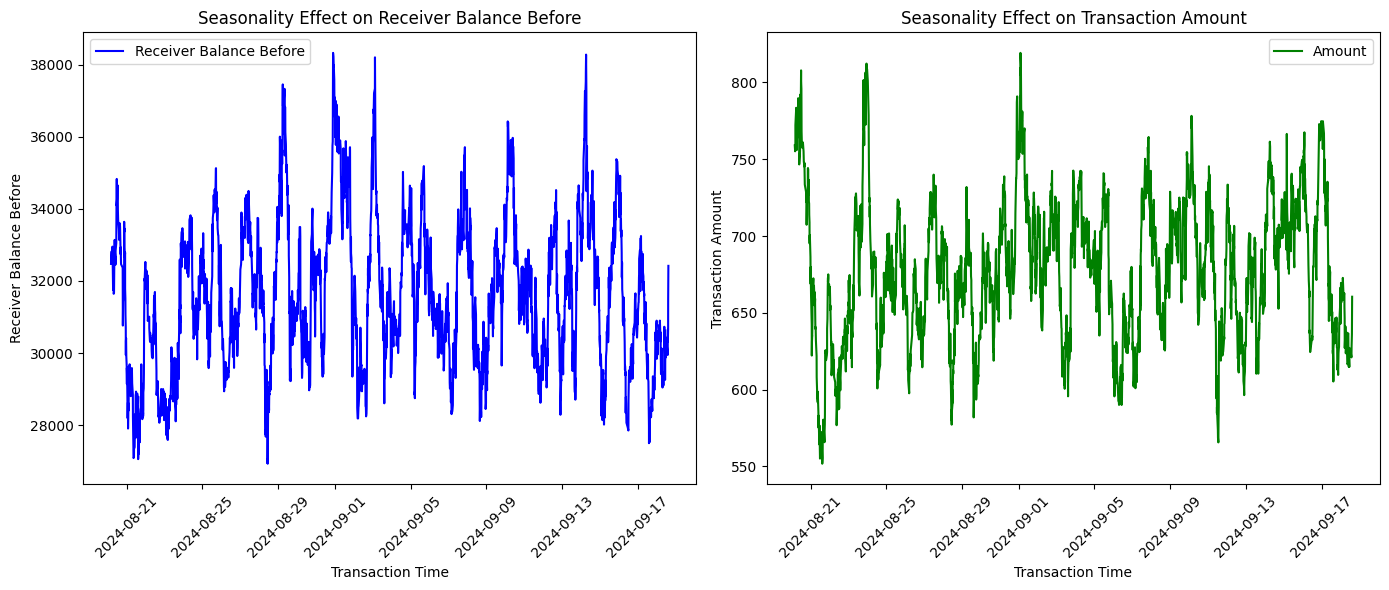

In [5]:
# Function to visualize seasonality in transaction data
def visualize_seasonality(df):
    """
    Visualize the seasonality effect on receiver balance and transaction amount.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    # Sort transactions by time
    df_sorted = df.sort_values(by='transaction_time')

    # Apply rolling mean to smooth out the spikes
    window_size = 50
    df_sorted['receiver_balance_smooth'] = df_sorted['receiver_balance_before'].rolling(window=window_size).mean()
    df_sorted['amount_smooth'] = df_sorted['amount'].rolling(window=window_size).mean()

    # Plot receiver_balance_before and amount against time
    plt.figure(figsize=(14, 6))

    # Receiver balance plot
    plt.subplot(1, 2, 1)
    plt.plot(df_sorted['transaction_time'], df_sorted['receiver_balance_smooth'], label='Receiver Balance Before', color='blue')
    plt.xlabel('Transaction Time')
    plt.ylabel('Receiver Balance Before')
    plt.title('Seasonality Effect on Receiver Balance Before')
    plt.xticks(rotation=45)
    plt.legend()

    # Amount plot
    plt.subplot(1, 2, 2)
    plt.plot(df_sorted['transaction_time'], df_sorted['amount_smooth'], label='Amount', color='green')
    plt.xlabel('Transaction Time')
    plt.ylabel('Transaction Amount')
    plt.title('Seasonality Effect on Transaction Amount')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to visualize seasonality
visualize_seasonality(transaction_data)

In [6]:
# Select relevant features for anomaly detection
features = ['sender_balance_before', 'receiver_balance_before', 'amount']

# Apply StandardScaler to standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(transaction_data[features])

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df_scaled)

# Predict the anomalies (1 = normal, -1 = anomaly)
transaction_data['anomaly'] = iso_forest.predict(df_scaled)

# Convert anomaly labels to binary (0 = normal, 1 = anomaly)
transaction_data['anomaly'] = transaction_data['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Show the number of anomalies detected
print(transaction_data['anomaly'].value_counts())

anomaly
0    2850
1     150
Name: count, dtype: int64


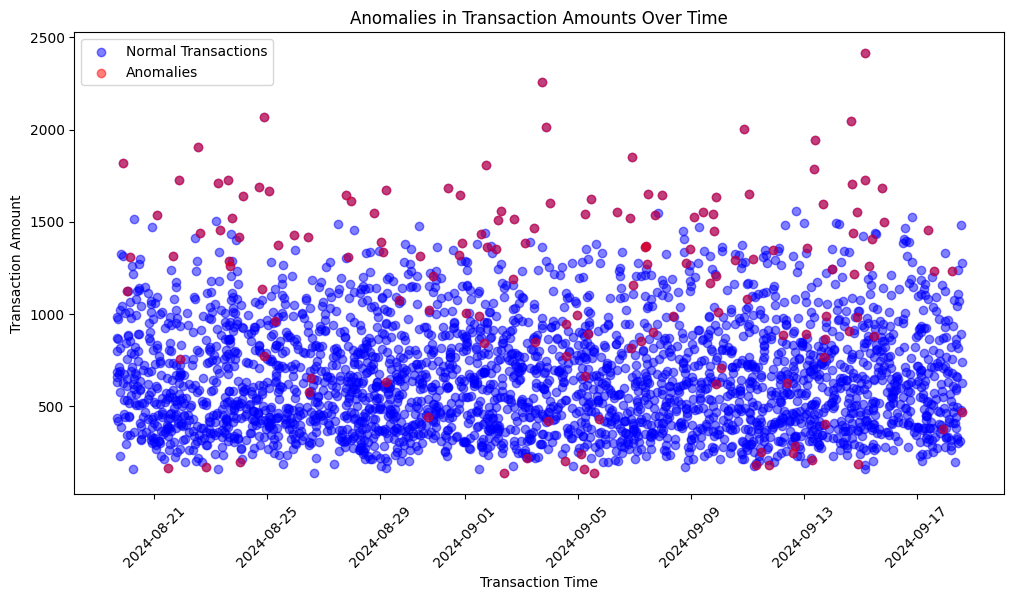

In [7]:
# Function to plot anomalies over time
def plot_anomalies_over_time(df):
    """
    Plot anomalies in transaction amounts over time.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    # Sort the data by transaction time
    df_sorted = df.sort_values(by='transaction_time')

    # Plot normal transactions and anomalies over time
    plt.figure(figsize=(12, 6))
    plt.scatter(df_sorted['transaction_time'], df_sorted['amount'], label='Normal Transactions', color='blue', alpha=0.5)
    plt.scatter(df_sorted[df_sorted['anomaly'] == 1]['transaction_time'], df_sorted[df_sorted['anomaly'] == 1]['amount'], label='Anomalies', color='red', alpha=0.5)
    plt.xlabel('Transaction Time')
    plt.ylabel('Transaction Amount')
    plt.title('Anomalies in Transaction Amounts Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Call the function to plot anomalies
plot_anomalies_over_time(transaction_data)

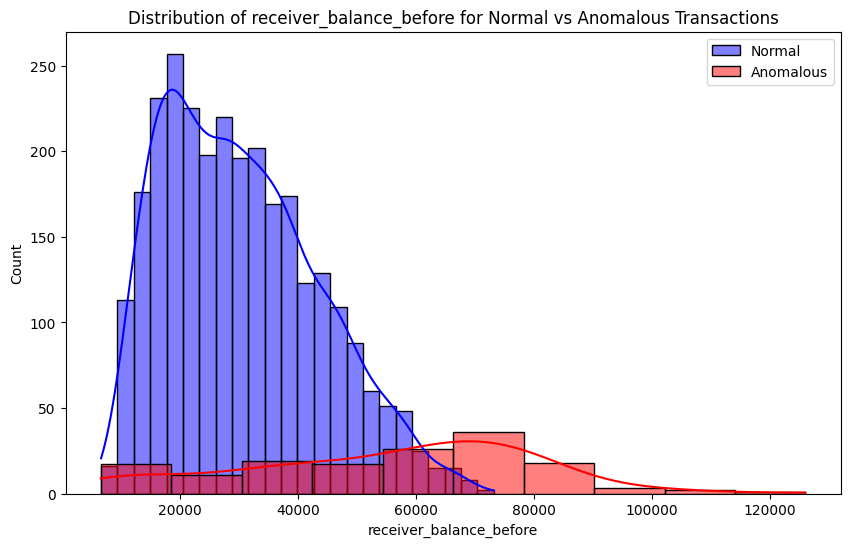

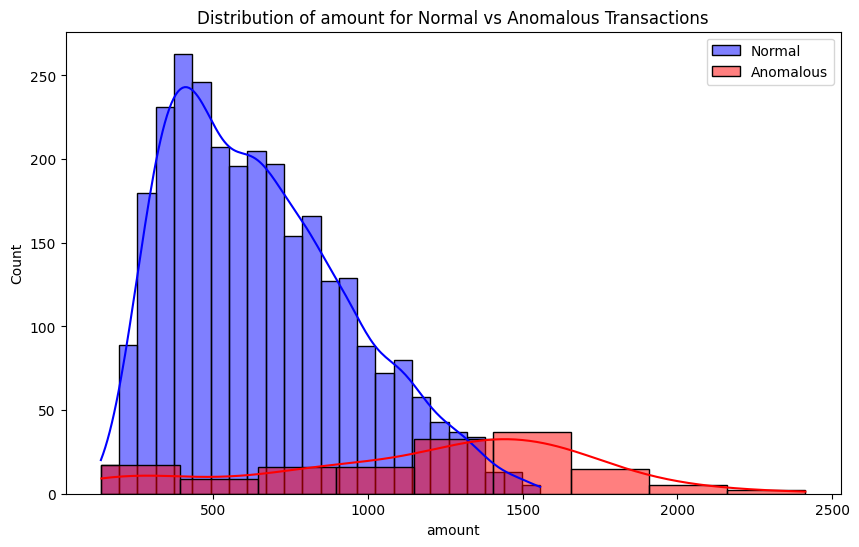

In [8]:
# Function to plot feature distribution for normal vs anomalous transactions
def plot_feature_distribution(df, feature):
    """
    Plot distribution of a feature for normal vs anomalous transactions.
    
    Parameters:
    - df: DataFrame containing transaction data.
    - feature: The feature to plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot distribution of the feature for normal transactions
    sns.histplot(df[df['anomaly'] == 0][feature], color='blue', label='Normal', kde=True)
    
    # Plot distribution of the feature for anomalous transactions
    sns.histplot(df[df['anomaly'] == 1][feature], color='red', label='Anomalous', kde=True)
    
    plt.title(f'Distribution of {feature} for Normal vs Anomalous Transactions')
    plt.legend()
    plt.show()

# Call the function for specific features
plot_feature_distribution(transaction_data, 'receiver_balance_before')
plot_feature_distribution(transaction_data, 'amount')

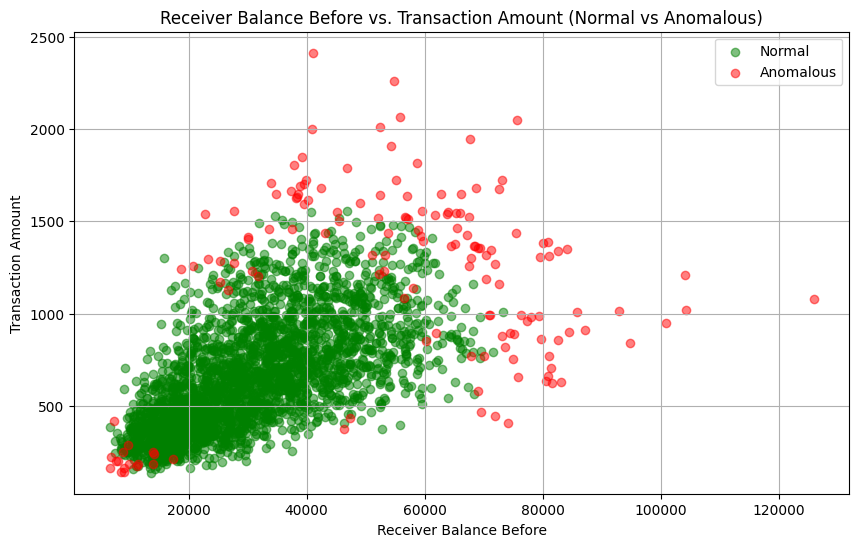

In [9]:
# Function to plot balance vs amount for normal vs anomalous transactions
def plot_balance_vs_amount(df):
    """
    Plot receiver balance before vs transaction amount for normal vs anomalous transactions.
    
    Parameters:
    - df: DataFrame containing transaction data.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot normal transactions
    plt.scatter(df[df['anomaly'] == 0]['receiver_balance_before'], 
                df[df['anomaly'] == 0]['amount'], 
                color='green', label='Normal', alpha=0.5)
    
    # Plot anomalous transactions
    plt.scatter(df[df['anomaly'] == 1]['receiver_balance_before'], 
                df[df['anomaly'] == 1]['amount'], 
                color='red', label='Anomalous', alpha=0.5)
    
    plt.xlabel('Receiver Balance Before')
    plt.ylabel('Transaction Amount')
    plt.title('Receiver Balance Before vs. Transaction Amount (Normal vs Anomalous)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot balance vs amount
plot_balance_vs_amount(transaction_data)